# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2025-08-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8) # How about if i get more than 8 years of data?

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date,auto_adjust=False).stack()
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-08-28 A        59.739979   63.459999   63.580002   62.970001   63.099998   
           AAPL     37.716026   40.367500   40.500000   39.982498   40.035000   
           ABBV     52.091984   73.320000   73.570000   72.559998   72.669998   
           ABT      43.649651   50.259998   50.349998   49.520000   49.540001   
           ACGL     30.542860   32.119999   32.430000   31.956667   32.383331   
...                       ...         ...         ...         ...         ...   
2025-08-22 XYZ      79.120003   79.120003   79.385002   73.470001   73.550003   
           YUM     147.869995  147.869995  149.960007  147.399994  148.600006   
           ZBH     107.709999  107.709999  107.769997  104.849998  105.250000   
           ZBRA    322.790009  322.790009  324.260010  310.329987  310.329987   
           ZTS     156.619995  156.619995  158.300003  156.139999  157.059998   

Price                   volume  
date       ticker               
2017-08-28 A         1290400.0  
           AAPL    103864000.0  
           ABBV      4574400.0  
           ABT       6126900.0  
           ACGL      2432700.0  
...                        ...  
2025-08-22 XYZ      12027900.0  
           YUM       1995300.0  
           ZBH       1099300.0  
           ZBRA       495400.0  
           ZTS       2426300.0  

[992241 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df


Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-08-28 A        59.739979   63.459999   63.580002   62.970001   63.099998   
           AAPL     37.716026   40.367500   40.500000   39.982498   40.035000   
           ABBV     52.091984   73.320000   73.570000   72.559998   72.669998   
           ABT      43.649651   50.259998   50.349998   49.520000   49.540001   
           ACGL     30.542860   32.119999   32.430000   31.956667   32.383331   
...                       ...         ...         ...         ...         ...   
2025-08-22 XYZ      79.120003   79.120003   79.385002   73.470001   73.550003   
           YUM     147.869995  147.869995  149.960007  147.399994  148.600006   
           ZBH     107.709999  107.709999  107.769997  104.849998  105.250000   
           ZBRA    322.790009  322.790009  324.260010  310.329987  310.329987   
           ZTS     156.619995  156.619995  158.300003  156.139999  157.059998   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-08-28 A         1290400.0         -0.001110        NaN       NaN   
           AAPL    103864000.0         -0.001293        NaN       NaN   
           ABBV      4574400.0         -0.042719        NaN       NaN   
           ABT       6126900.0         -0.006052        NaN       NaN   
           ACGL      2432700.0         -0.001214        NaN       NaN   
...                        ...               ...        ...       ...   
2025-08-22 XYZ      12027900.0          0.000939  60.372712  4.294030   
           YUM       1995300.0          0.000139  52.575231  4.941597   
           ZBH       1099300.0          0.000171  68.257640  4.492735   
           ZBRA       495400.0          0.000365  51.996071  5.704461   
           ZTS       2426300.0          0.000091  55.001270  4.977662   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-08-28 A            NaN       NaN       NaN       NaN      77.088469  
           AAPL         NaN       NaN       NaN       NaN    3917.337356  
           ABBV         NaN       NaN       NaN       NaN     238.289571  
           ABT          NaN       NaN       NaN       NaN     267.437044  
           ACGL         NaN       NaN       NaN       NaN      74.301616  
...                     ...       ...       ...       ...            ...  
2025-08-22 XYZ     4.343620  4.393211 -0.575384  0.186652     951.647481  
           YUM     4.985865  5.030134  1.152172  0.311744     295.045001  
           ZBH     4.600933  4.709131 -0.456652  1.380315     118.405602  
           ZBRA    5.778280  5.852100  0.631785 -0.282978     159.910170  
           ZTS     5.023337  5.069011  0.084729  0.168868     380.007094  

[992241 rows x 14 columns]

<Axes: xlabel='date'>

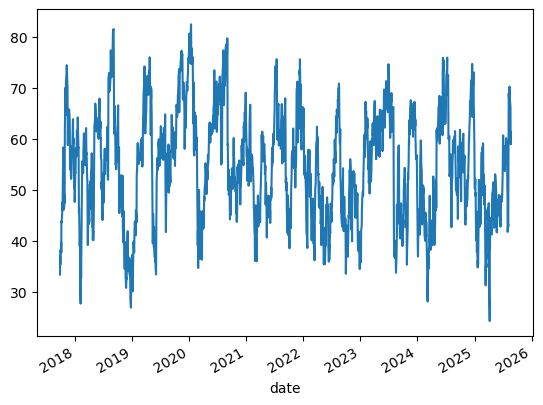

In [3]:
#Check out Value 
df.xs('AAPL',level=1)['rsi'].plot()

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [4]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-10-31 A           90.095143   64.174026         -0.001087  64.728194   
           AAPL      3402.315089   39.484234         -0.001316  69.962825   
           ABBV       417.244843   64.567650         -0.044945  54.955840   
           ABT        272.129846   47.327904         -0.007607  53.263768   
           ACGL        49.101617   31.582510         -0.000997  52.293306   
...                          ...         ...               ...        ...   
2025-08-31 XYZ        671.473157   79.120003          0.000939  60.372712   
           YUM        342.956560  147.869995          0.000139  52.575231   
           ZBH        180.231756  107.709999          0.000171  68.257640   
           ZBRA       235.008070  322.790009          0.000365  51.996071   
           ZTS        522.806018  156.619995          0.000091  55.001270   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-10-31 A       4.142041  4.161062  4.180084 -1.818880  0.189921  
           AAPL    3.589090  3.635955  3.682821 -1.374718 -0.103190  
           ABBV    4.153099  4.199430  4.245761 -0.176762  0.302510  
           ABT     3.868742  3.892300  3.915859 -1.667682  0.187416  
           ACGL    3.464891  3.488365  3.511840 -1.230855  0.022223  
...                     ...       ...       ...       ...       ...  
2025-08-31 XYZ     4.294030  4.343620  4.393211 -0.575384  0.186652  
           YUM     4.941597  4.985865  5.030134  1.152172  0.311744  
           ZBH     4.492735  4.600933  4.709131 -0.456652  1.380315  
           ZBRA    5.704461  5.778280  5.852100  0.631785 -0.282978  
           ZTS     4.977662  5.023337  5.069011  0.084729  0.168868  

[46945 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [5]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-09-30 AAPL     53.525421         -0.000884  61.186137  3.953861   
           ABBV     69.559967         -0.034926  49.718875  4.223081   
           ABT      64.929497         -0.004971  79.127068  4.054769   
           ACN     152.580551         -0.004457  54.490777  5.019864   
           ADBE    269.950012          0.000100  56.971110  5.555771   
...                       ...               ...        ...       ...   
2025-08-31 WDAY    221.270004          0.000776  43.206616  5.366261   
           WFC      79.099998          0.000076  51.645758  4.333795   
           WMT      96.830002          0.000211  44.864282  4.571945   
           XOM     111.279999          0.000045  58.379345  4.647582   
           XYZ      79.120003          0.000939  60.372712  4.294030   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-09-30 AAPL    3.983711  4.013561 -1.133439 -0.025163  
           ABBV    4.250270  4.277459 -0.988108 -0.398545  
           ABT     4.123610  4.192450 -1.488256  1.040372  
           ACN     5.039856  5.059848 -1.421522  0.170413  
           ADBE    5.587446  5.619120 -1.200105  0.191003  
...                     ...       ...       ...       ...  
2025-08-31 WDAY    5.425941  5.485621  0.253728 -0.588843  
           WFC     4.376351  4.418907  1.039516 -0.503282  
           WMT     4.617124  4.662303  2.146428  0.409775  
           XOM     4.688375  4.729168 -0.023227 -0.170654  
           XYZ     4.343620  4.393211 -0.575384  0.186652  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [6]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-09-30 AAPL     53.929817         -0.000073  60.753892  3.936588   
           ABBV     58.610977         -0.023164  69.713139  3.938414   
           ABT      75.290627         -0.002621  49.178265  4.311257   
           ACN     175.454910         -0.002904  48.714219  5.152078   
           ADBE    276.250000          0.000089  44.473157  5.611829   
...                       ...               ...        ...       ...   
2025-08-31 WDAY    221.270004          0.000776  43.206616  5.366261   
           WFC      79.099998          0.000076  51.645758  4.333795   
           WMT      96.830002          0.000211  44.864282  4.571945   
           XOM     111.279999          0.000045  58.379345  4.647582   
           XYZ      79.120003          0.000939  60.372712  4.294030   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-09-30 AAPL    3.979289  4.021990 -1.138494  0.062267   0.072962   
           ABBV    4.018399  4.098385 -1.241558  0.499572   0.151810   
           ABT     4.335812  4.360367 -0.590575 -0.586708  -0.019339   
           ACN     5.181646  5.211215 -0.760767 -0.244416  -0.029368   
           ADBE    5.638405  5.664982 -0.820773 -0.340215  -0.029032   
...                     ...       ...       ...       ...        ...   
2025-08-31 WDAY    5.425941  5.485621  0.253728 -0.588843  -0.035356   
           WFC     4.376351  4.418907  1.039516 -0.503282  -0.013212   
           WMT     4.617124  4.662303  2.146428  0.409775  -0.009429   
           XOM     4.688375  4.729168 -0.023227 -0.170654   0.006051   
           XYZ     4.343620  4.393211 -0.575384  0.186652   0.024075   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-09-30 AAPL     0.027278   0.043396   0.029148   0.041098    0.000627  
           ABBV     0.066112   0.018692  -0.005655  -0.017218   -0.011740  
           ABT     -0.019888  -0.000463   0.008944   0.017721    0.012414  
           ACN     -0.000597   0.013492   0.016293   0.036050    0.011709  
           ADBE    -0.038571  -0.021265   0.006013   0.022438    0.001924  
...                      ...        ...        ...        ...         ...  
2025-08-31 WDAY    -0.039813  -0.036926  -0.028594  -0.013468   -0.014354  
           WFC     -0.003472   0.020888   0.003546   0.006018    0.027385  
           WMT     -0.003708  -0.005650  -0.001786   0.006180    0.019850  
           XOM      0.020729   0.031624   0.003001  -0.003434   -0.001882  
           XYZ      0.079226   0.086133   0.032513  -0.012433    0.015121  

[10304 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [7]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 AAPL    0.0142  0.0029  0.0676  0.0182  0.0338   0.072962
           ABBV    0.0142  0.0029  0.0676  0.0182  0.0338   0.151810
           ABT     0.0142  0.0029  0.0676  0.0182  0.0338  -0.019339
           ACN     0.0142  0.0029  0.0676  0.0182  0.0338  -0.029368
           ADBE    0.0142  0.0029  0.0676  0.0182  0.0338  -0.029032
...                   ...     ...     ...     ...     ...        ...
2025-06-30 WDAY    0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.031125
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763
           XYZ     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.100081

[10024 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [8]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 AAPL    0.0142  0.0029  0.0676  0.0182  0.0338   0.072962
           ABBV    0.0142  0.0029  0.0676  0.0182  0.0338   0.151810
           ABT     0.0142  0.0029  0.0676  0.0182  0.0338  -0.019339
           ACN     0.0142  0.0029  0.0676  0.0182  0.0338  -0.029368
           ADBE    0.0142  0.0029  0.0676  0.0182  0.0338  -0.029032
...                   ...     ...     ...     ...     ...        ...
2025-06-30 WDAY    0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.031125
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763
           XYZ     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.100081

[9957 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [9]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-09-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-06-30 WDAY    1.156298 -1.233651  0.737005 -1.551159 -0.530020
           WFC     0.800624 -0.092904  0.524113 -1.716525 -0.053749
           WMT     0.551380  0.107182 -0.390095  0.259687 -0.913341
           XOM     0.330550 -0.272277  0.873620  0.680352  0.249376
           XYZ     2.114946  0.211749  0.083268 -4.299847 -0.211310

[9957 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [10]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10072 entries, (Timestamp('2019-09-30 00:00:00'), 'AAPL') to (Timestamp('2025-08-31 00:00:00'), 'XYZ')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10072 non-null  float64
 1   rsi               10072 non-null  float64
 2   bb_low            10072 non-null  float64
 3   bb_mid            10072 non-null  float64
 4   bb_high           10072 non-null  float64
 5   atr               10072 non-null  float64
 6   macd              10072 non-null  float64
 7   return_1m         10072 non-null  float64
 8   return_2m         10072 non-null  float64
 9   return_3m         10072 non-null  float64
 10  return_6m         10072 non-null  float64
 11  return_9m         10072 non-null  float64
 12  return_12m        10072 non-null  float64
 13  Mkt-RF            10072 non-null  float64
 14  SMB               10072 non-null  float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [11]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [12]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

  File "c:\Users\VAQ\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\VAQ\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VAQ\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\VAQ\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-09-30 AAPL           -0.000073  60.753892  3.936588  3.979289  4.021990   
           ABBV           -0.023164  69.713139  3.938414  4.018399  4.098385   
           ABT            -0.002621  49.178265  4.311257  4.335812  4.360367   
           ACN            -0.002904  48.714219  5.152078  5.181646  5.211215   
           ADBE            0.000089  44.473157  5.611829  5.638405  5.664982   
...                             ...        ...       ...       ...       ...   
2025-08-31 WDAY            0.000776  43.206616  5.366261  5.425941  5.485621   
           WFC             0.000076  51.645758  4.333795  4.376351  4.418907   
           WMT             0.000211  44.864282  4.571945  4.617124  4.662303   
           XOM             0.000045  58.379345  4.647582  4.688375  4.729168   
           XYZ             0.000939  60.372712  4.294030  4.343620  4.393211   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-09-30 AAPL   -1.138494  0.062267   0.072962   0.027278   0.043396   
           ABBV   -1.241558  0.499572   0.151810   0.066112   0.018692   
           ABT    -0.590575 -0.586708  -0.019339  -0.019888  -0.000463   
           ACN    -0.760767 -0.244416  -0.029368  -0.000597   0.013492   
           ADBE   -0.820773 -0.340215  -0.029032  -0.038571  -0.021265   
...                     ...       ...        ...        ...        ...   
2025-08-31 WDAY    0.253728 -0.588843  -0.035356  -0.039813  -0.036926   
           WFC     1.039516 -0.503282  -0.013212  -0.003472   0.020888   
           WMT     2.146428  0.409775  -0.009429  -0.003708  -0.005650   
           XOM    -0.023227 -0.170654   0.006051   0.020729   0.031624   
           XYZ    -0.575384  0.186652   0.024075   0.079226   0.086133   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-09-30 AAPL     0.029148   0.041098    0.000627  1.193823 -0.025046   
           ABBV    -0.005655  -0.017218   -0.011740  0.537492  0.050271   
           ABT      0.008944   0.017721    0.012414  0.789084 -0.081743   
           ACN      0.016293   0.036050    0.011709  1.142378 -0.174850   
           ADBE     0.006013   0.022438    0.001924  1.434960 -0.683106   
...                      ...        ...         ...       ...       ...   
2025-08-31 WDAY    -0.028594  -0.013468   -0.014354  1.162705 -0.568810   
           WFC      0.003546   0.006018    0.027385  1.066848 -0.123019   
           WMT     -0.001786   0.006180    0.019850  0.681733 -0.257054   
           XOM      0.003001  -0.003434   -0.001882  0.903366 -0.156000   
           XYZ      0.032513  -0.012433    0.015121  2.431101  0.421619   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-09-30 AAPL   -0.668320  0.435576  0.336210        3  
           ABBV   -0.016733  0.236515  0.676949        3  
           ABT    -0.282075  0.027198  0.937250        1  
           ACN    -0.233526  0.140306 -0.085701        1  
           ADBE   -0.168895  0.275806 -0.453124        1  
...                     ...       ...       ...      ...  
2025-08-31 WDAY   -0.285792 -0.890722 -0.567333        1  
           WFC     1.542243 -0.820986 -1.046200        2  
           WMT    -0.337829  0.245693  0.457939        1  
           XOM     0.973677 -0.285517  0.345936        2  
           XYZ    -0.058172 -2.301287 -0.167209        3  

[10072 rows x 19 columns]

In [13]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


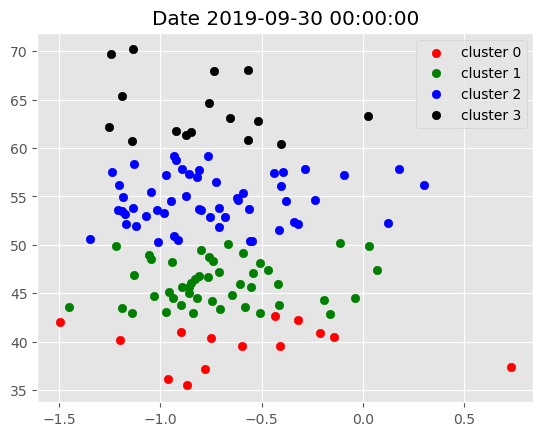

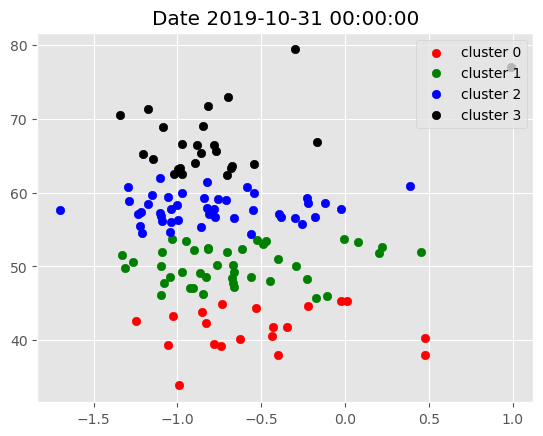

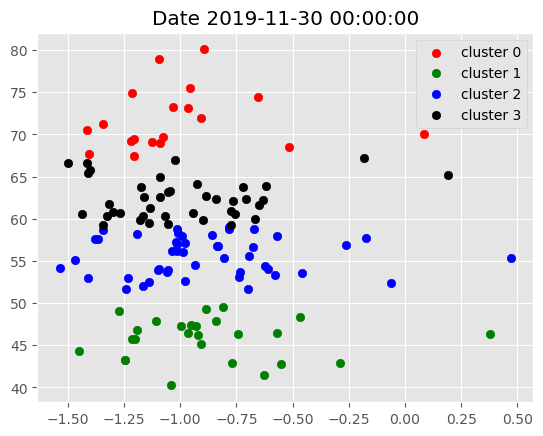

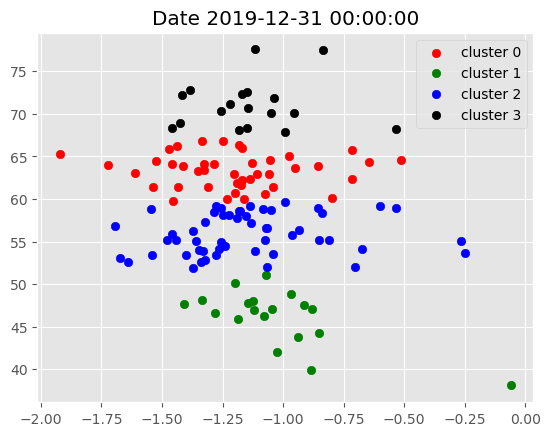

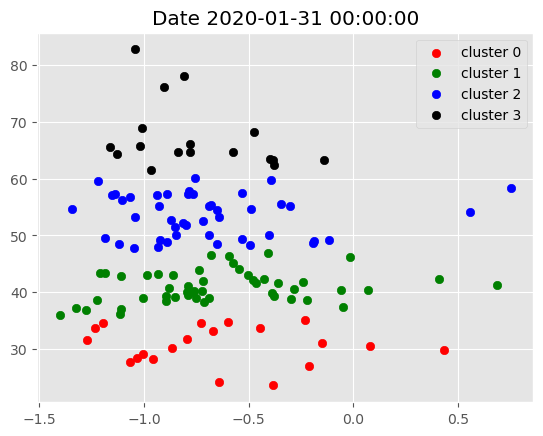

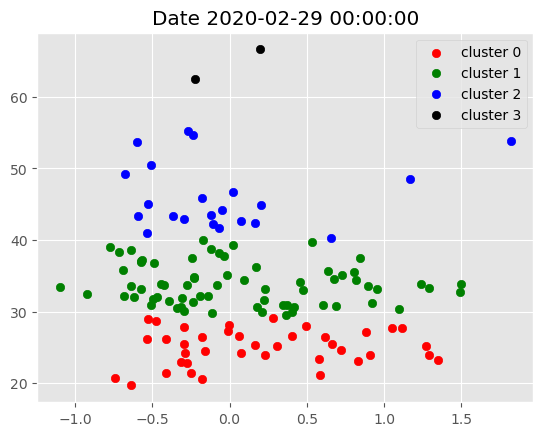

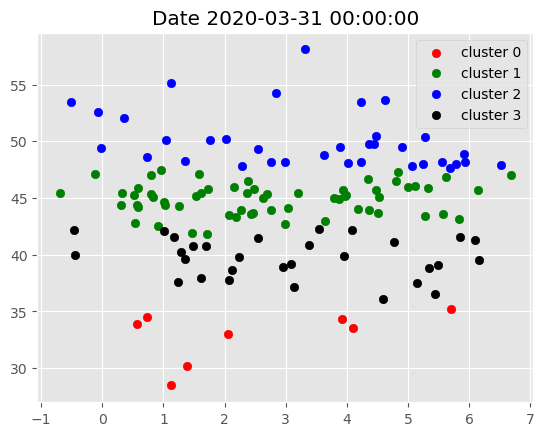

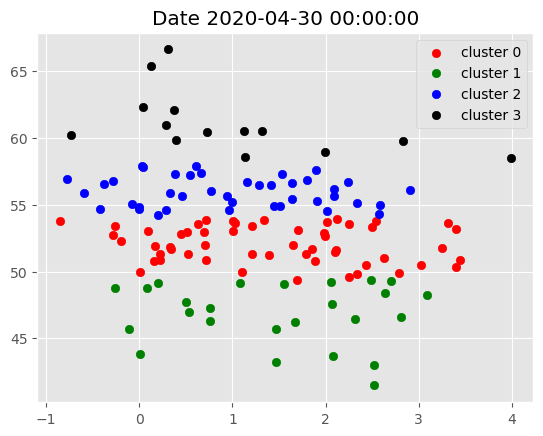

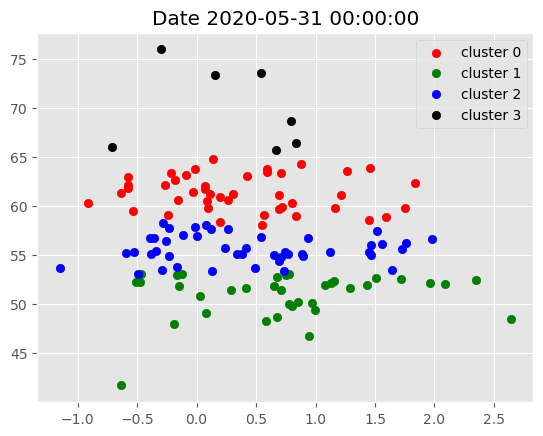

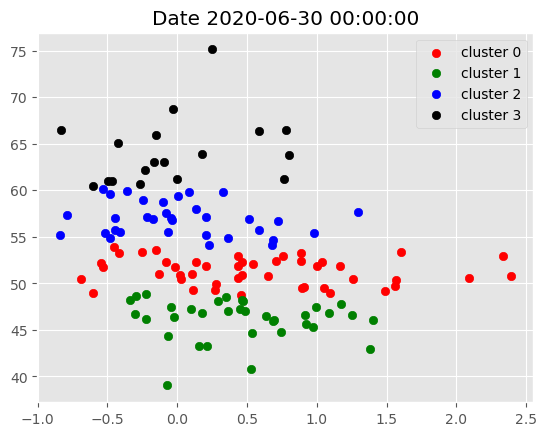

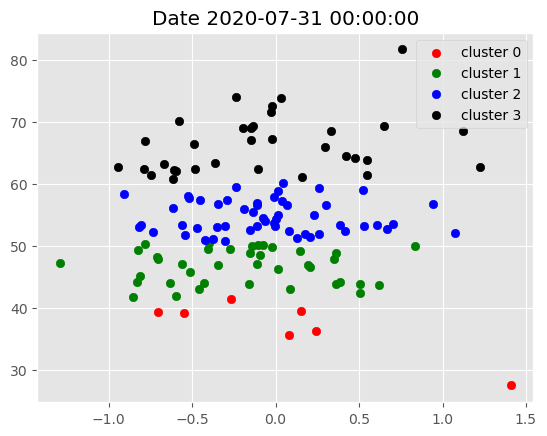

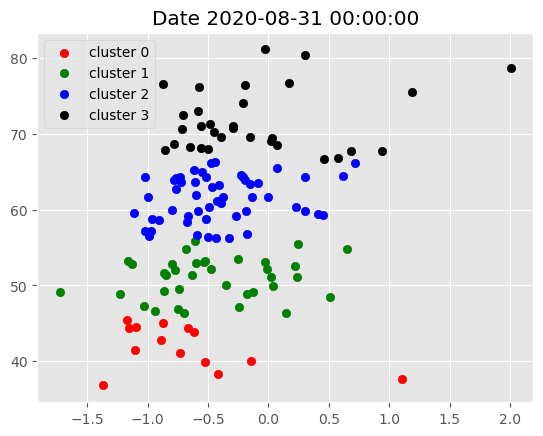

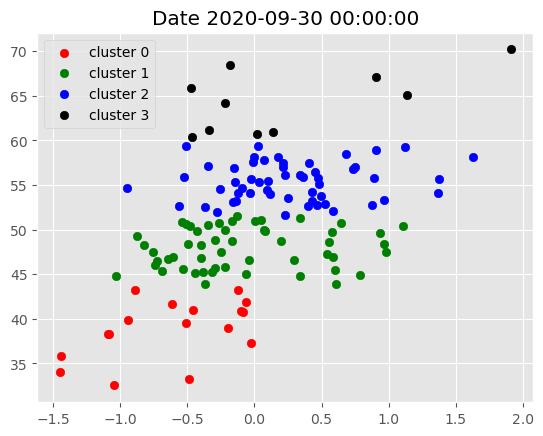

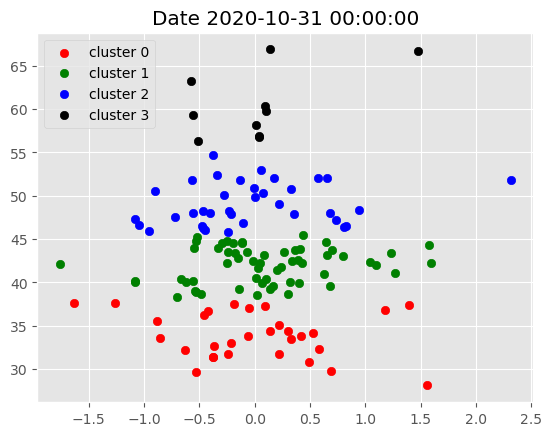

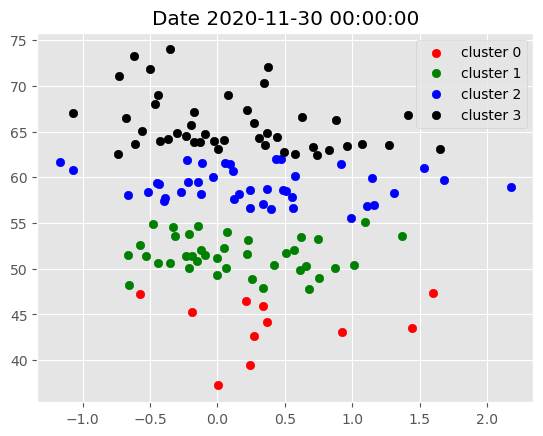

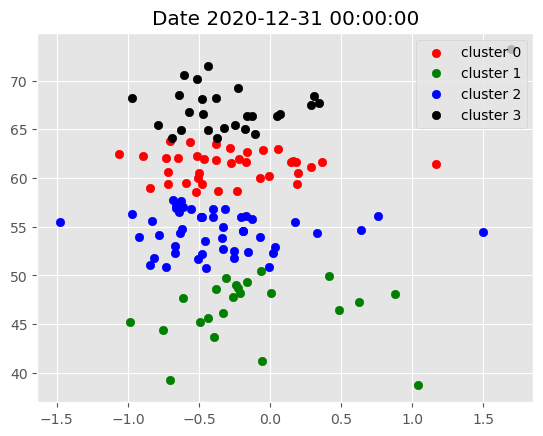

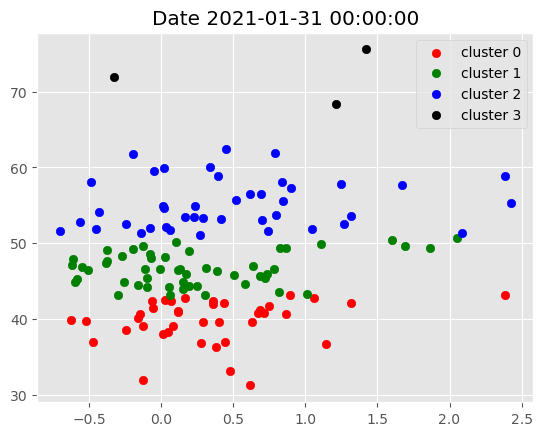

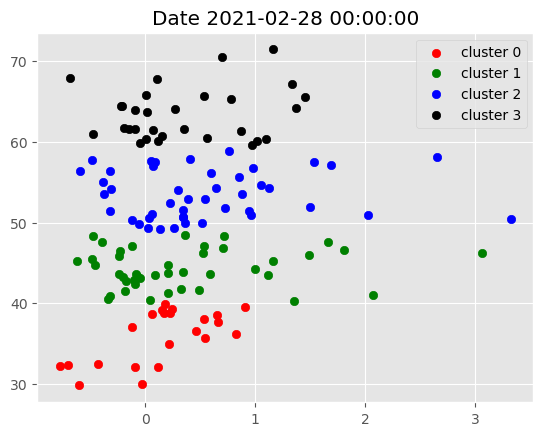

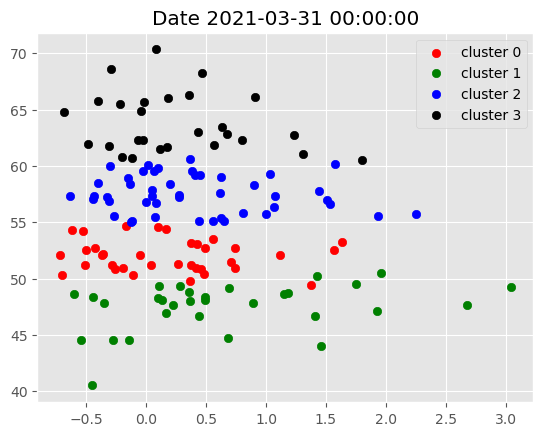

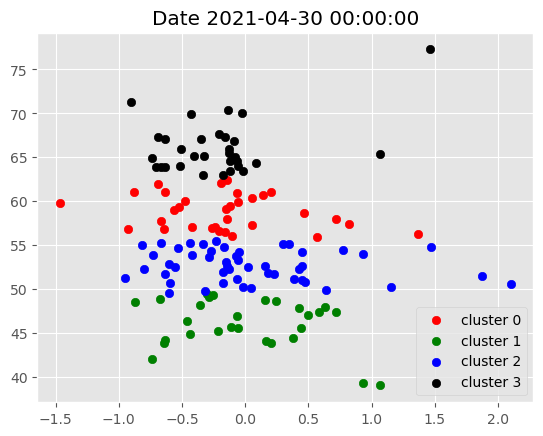

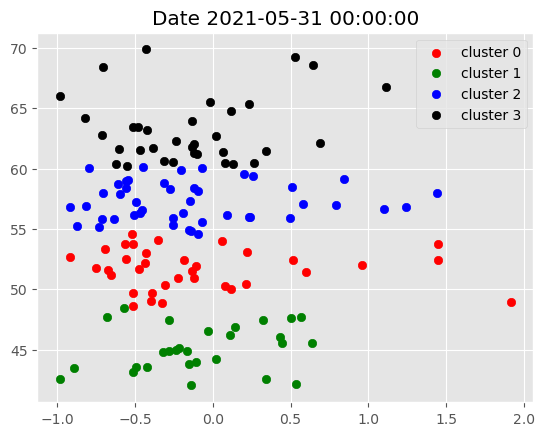

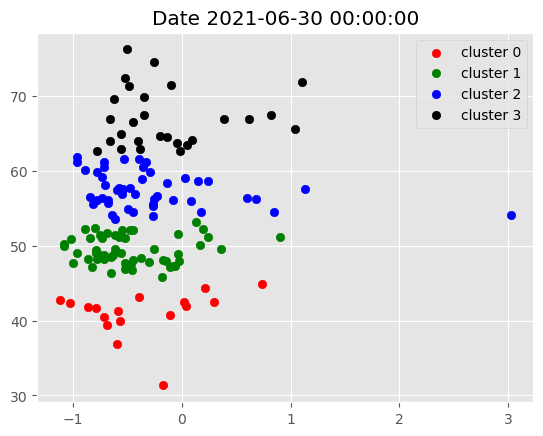

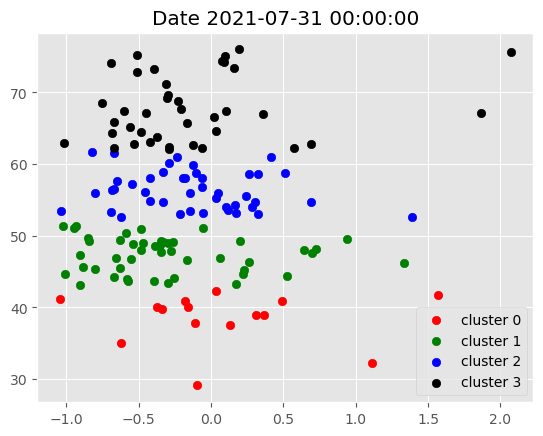

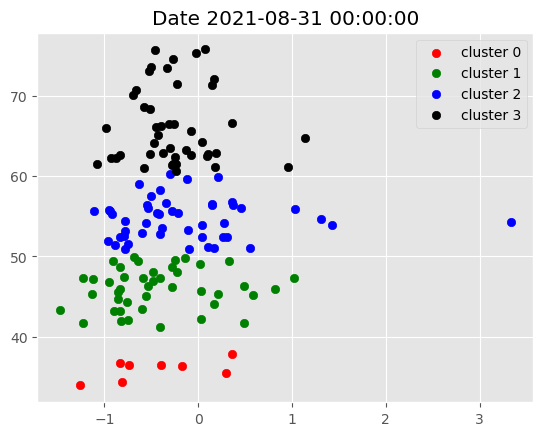

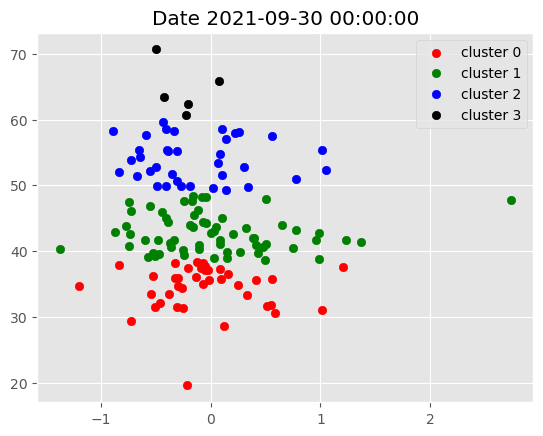

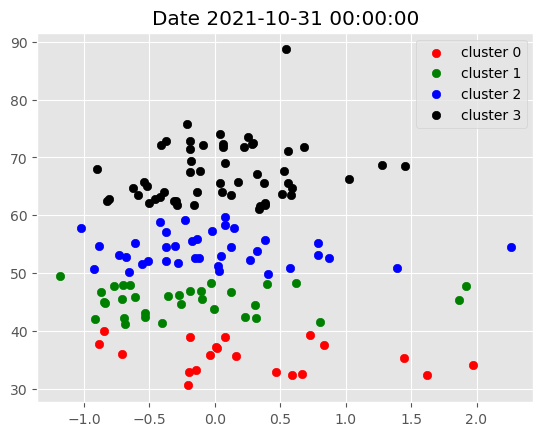

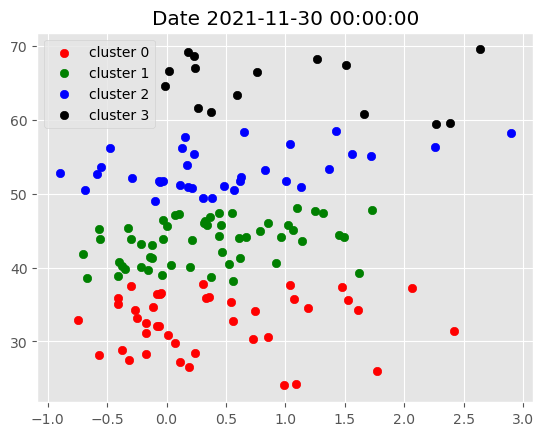

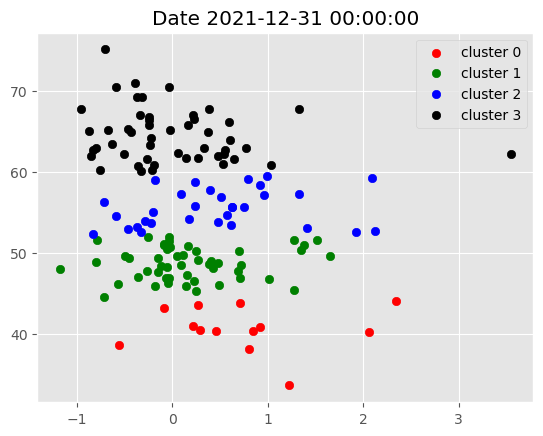

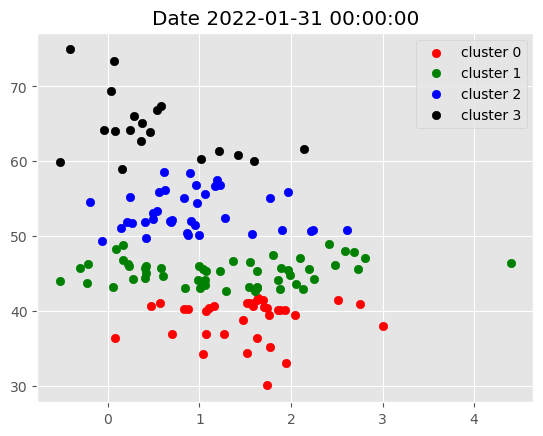

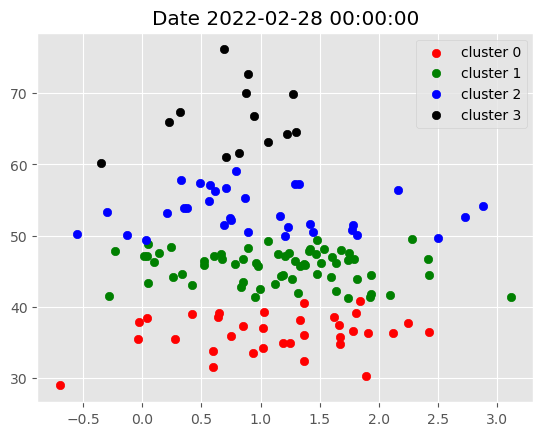

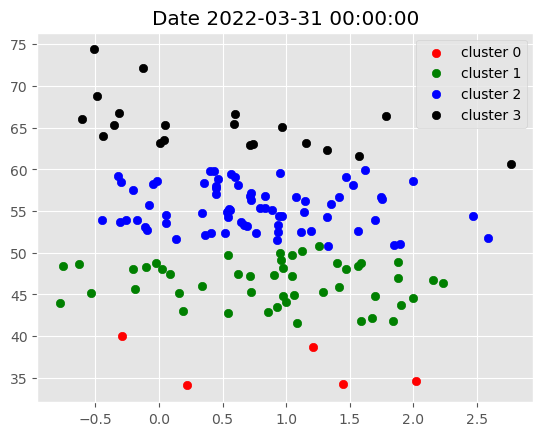

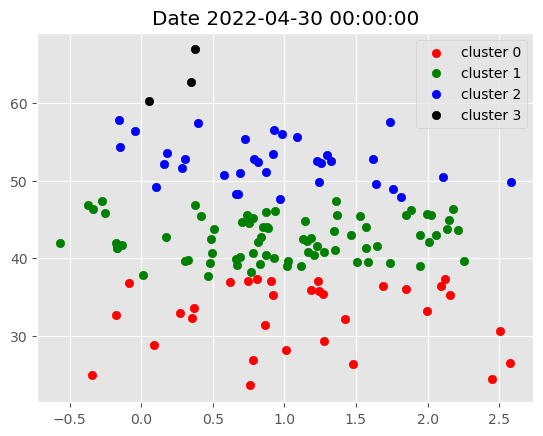

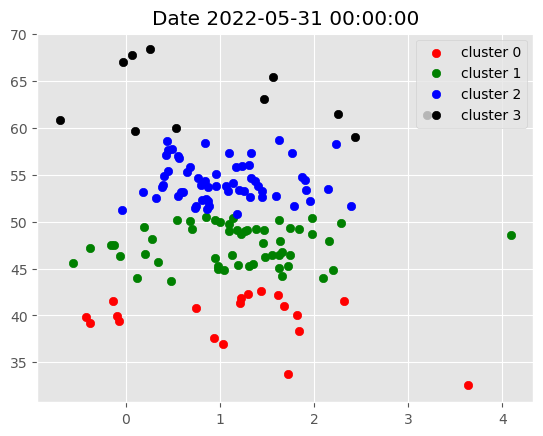

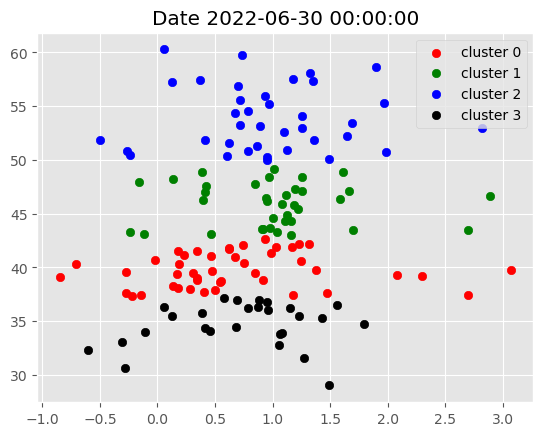

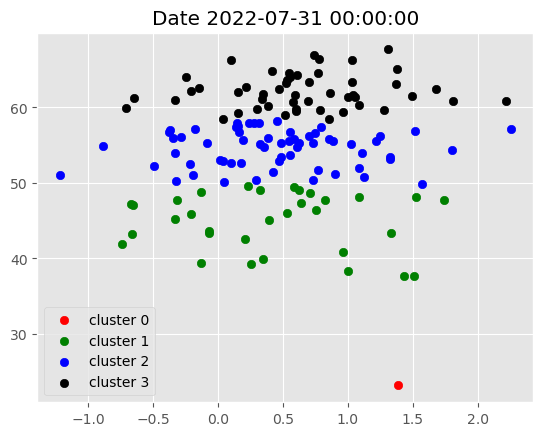

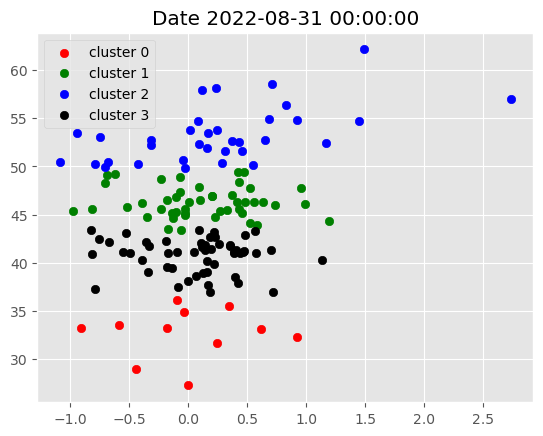

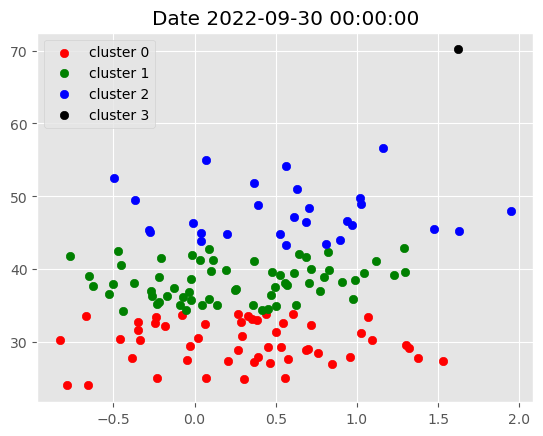

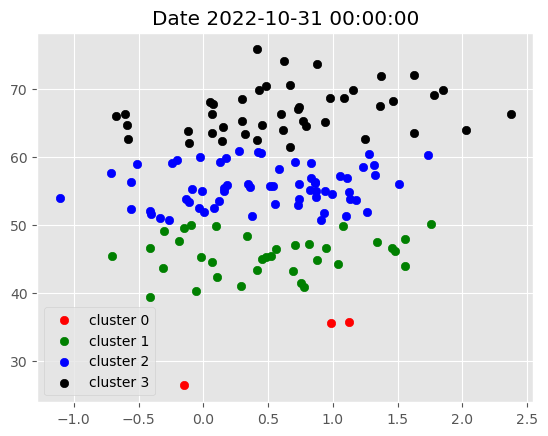

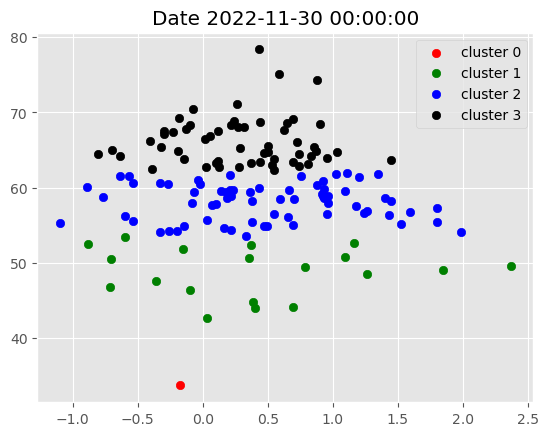

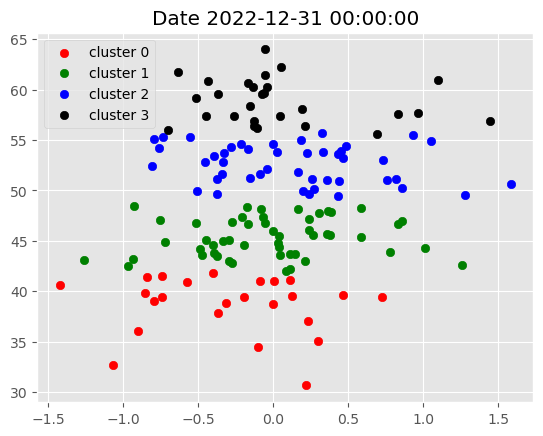

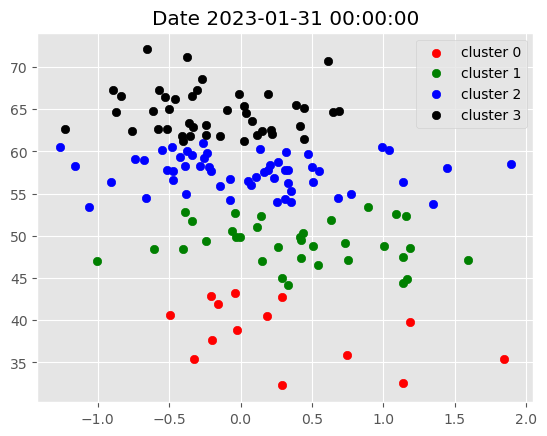

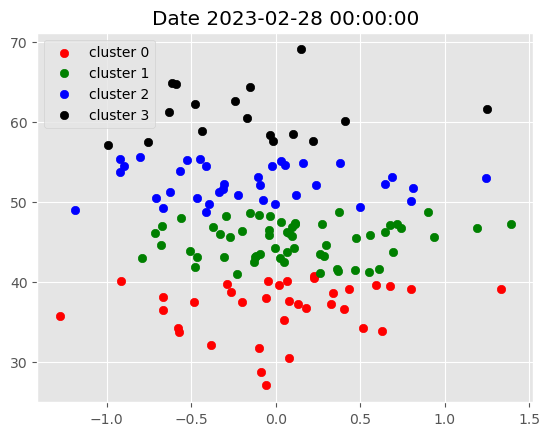

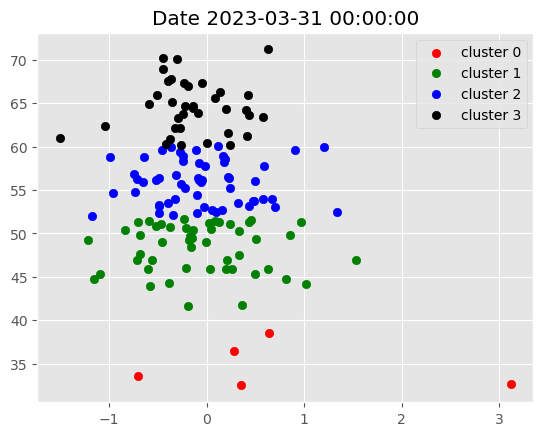

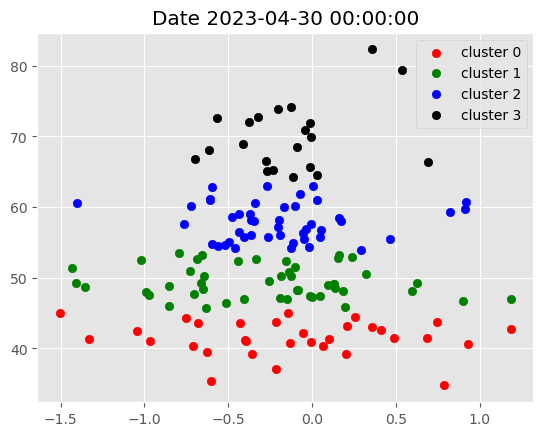

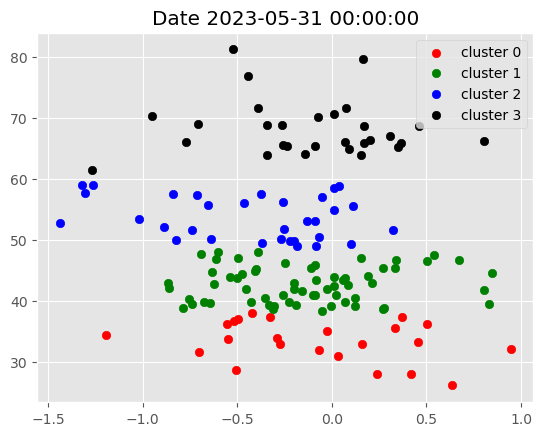

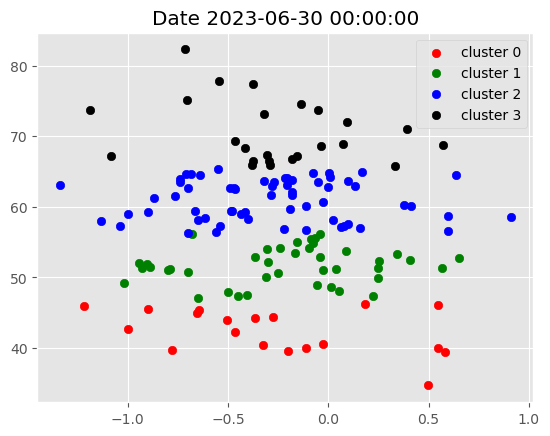

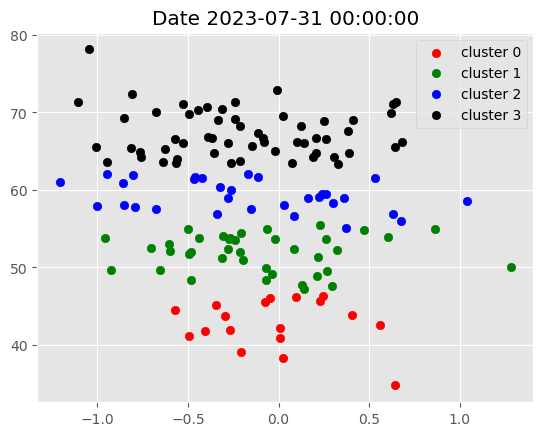

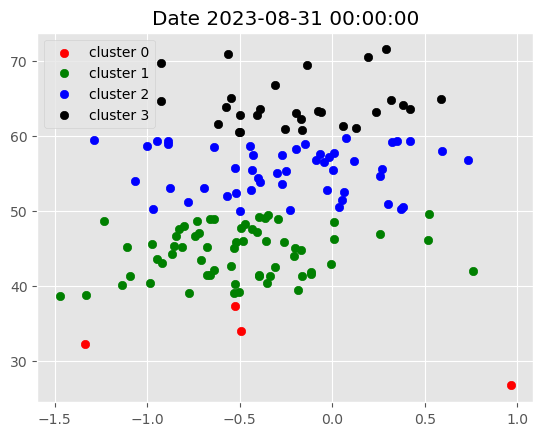

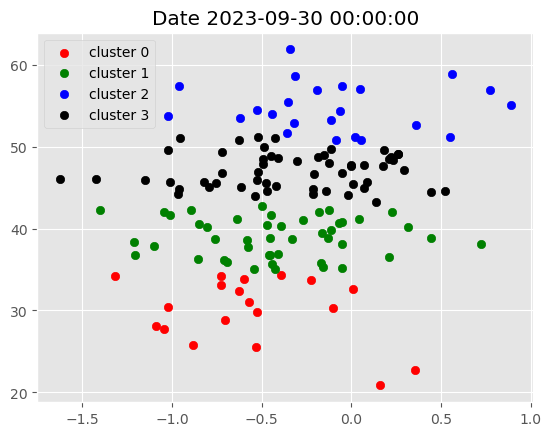

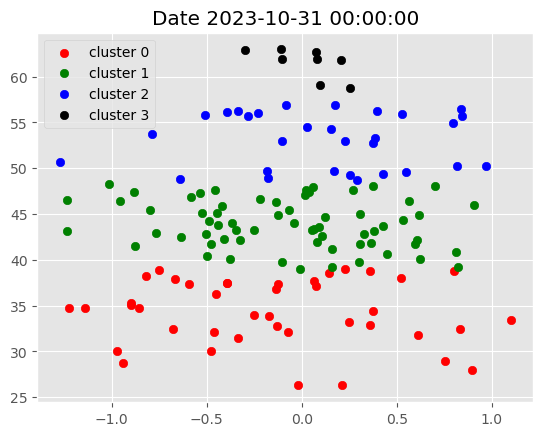

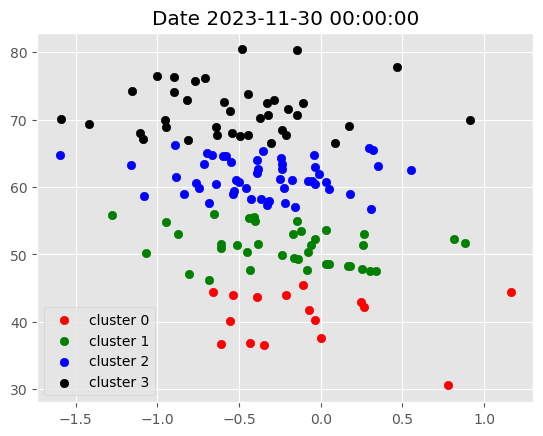

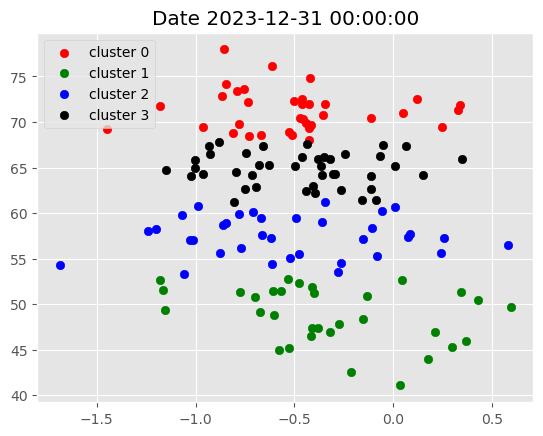

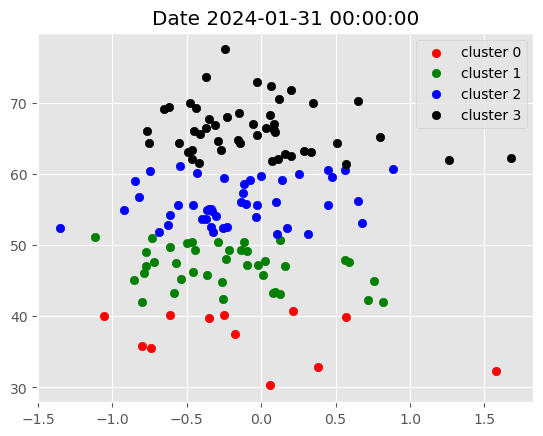

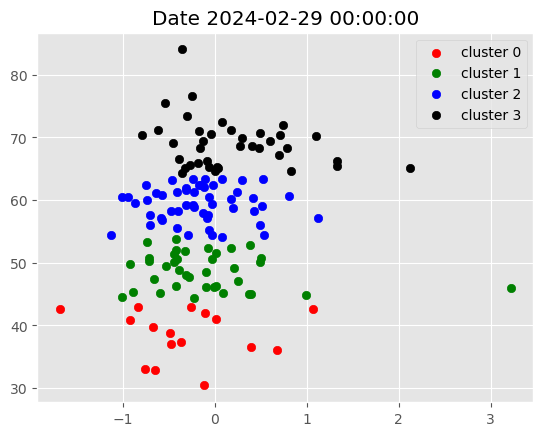

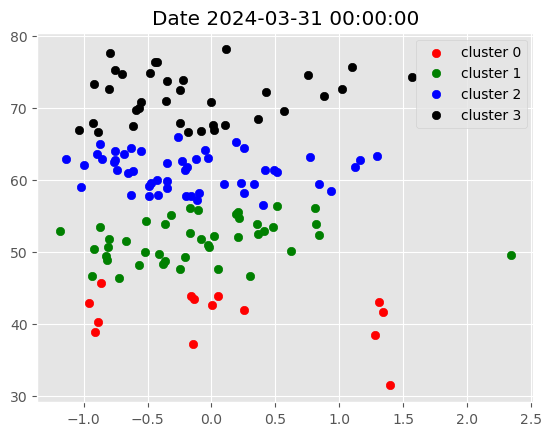

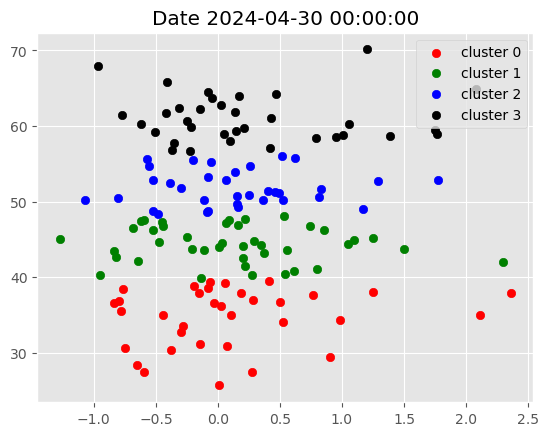

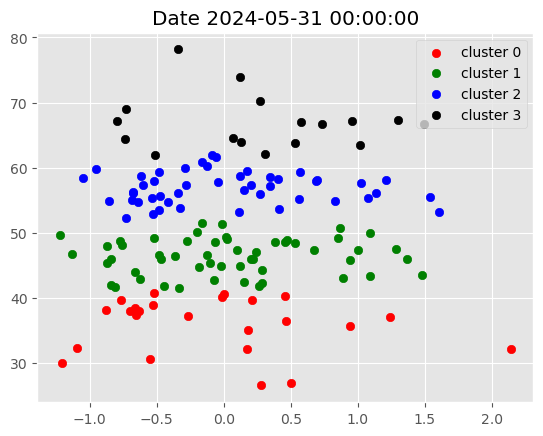

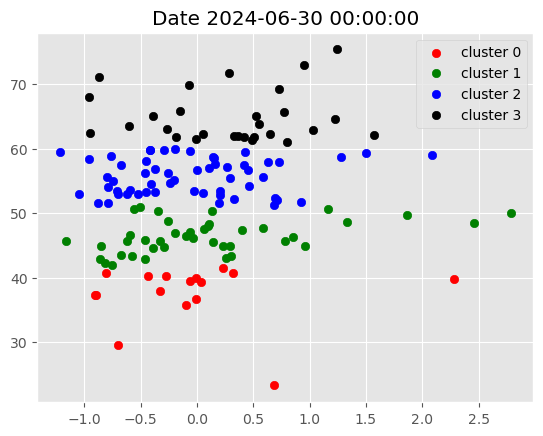

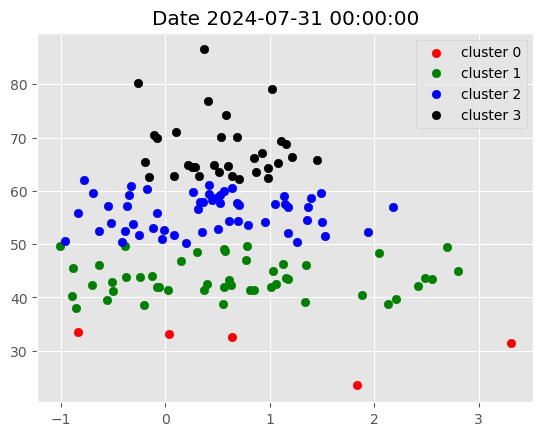

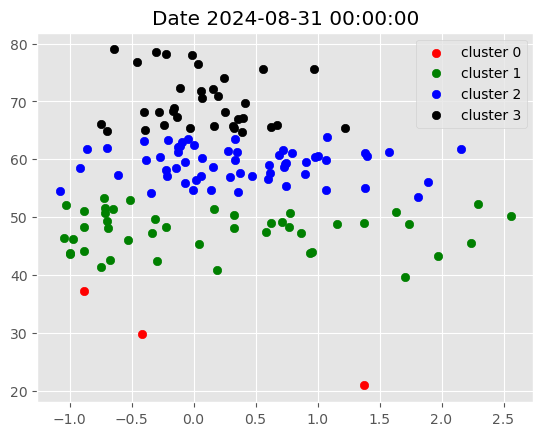

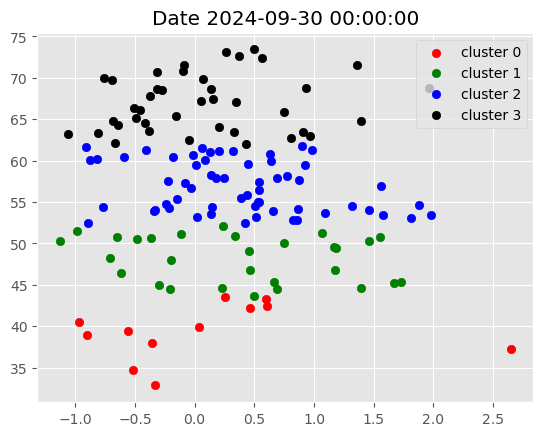

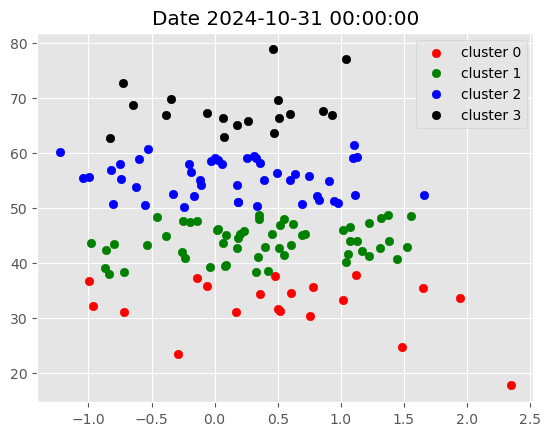

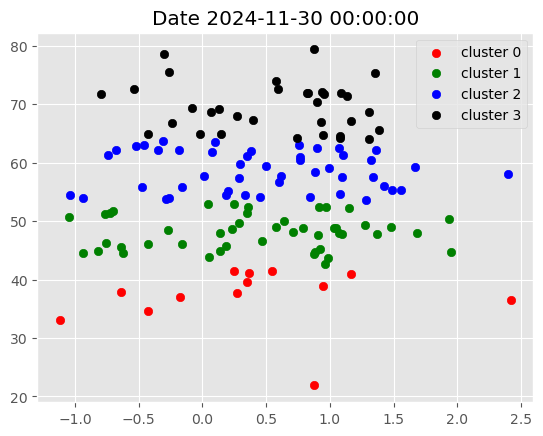

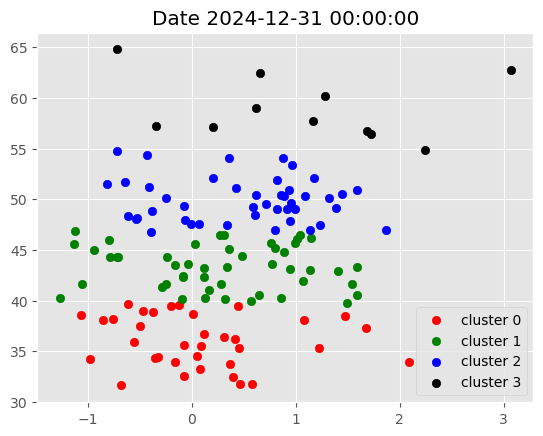

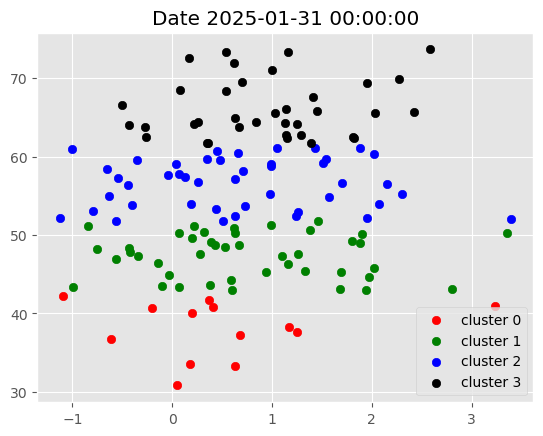

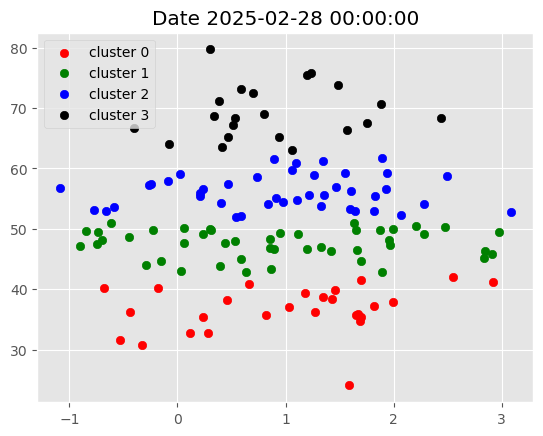

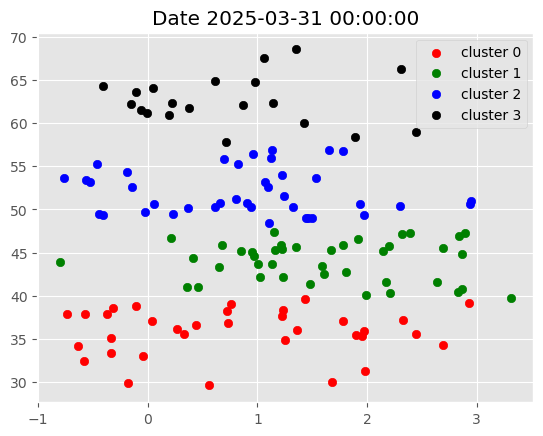

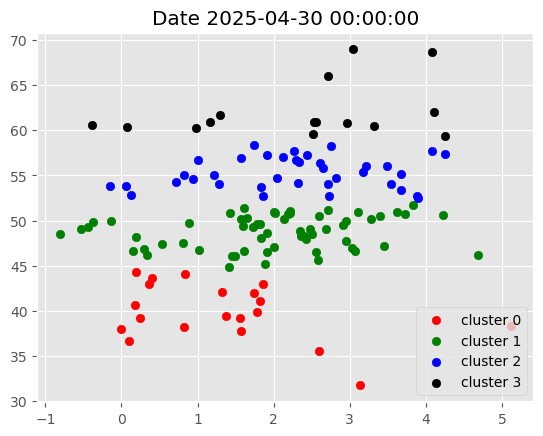

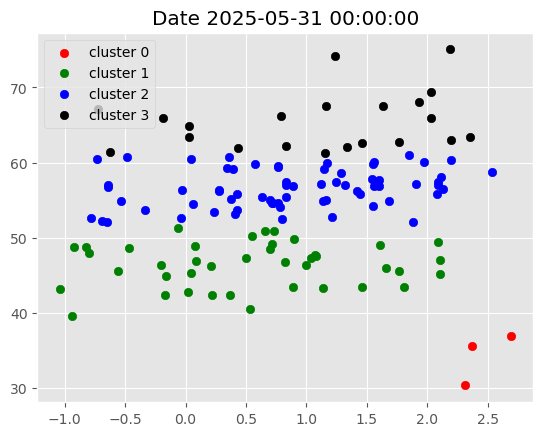

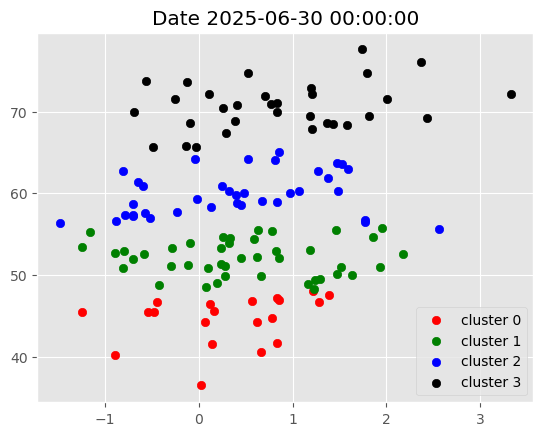

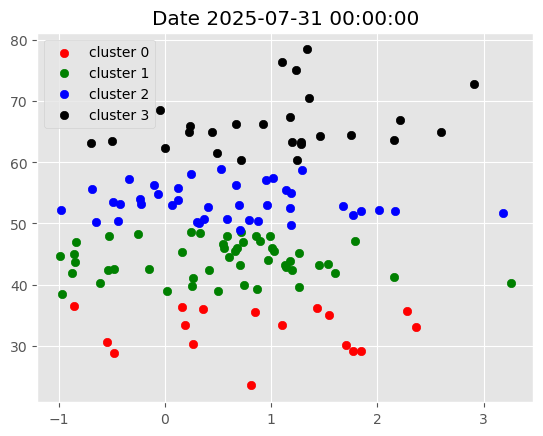

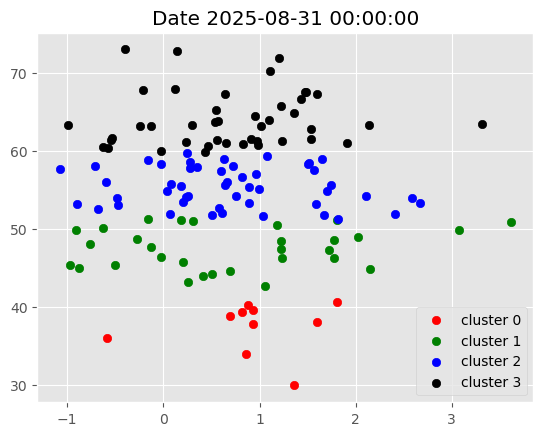

In [14]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [15]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2019-10-01': ['AAPL',
  'ABBV',
  'BMY',
  'DE',
  'HD',
  'IBM',
  'MPC',
  'NEE',
  'NKE',
  'PG',
  'SHW',
  'T',
  'TGT',
  'VZ',
  'WFC',
  'WMT'],
 '2019-11-01': ['AAPL',
  'ABBV',
  'ALGN',
  'AMD',
  'AMGN',
  'BIIB',
  'BMY',
  'CAT',
  'CHTR',
  'CI',
  'GE',
  'INTC',
  'JPM',
  'LRCX',
  'MS',
  'NEE',
  'NVDA',
  'PANW',
  'PFE',
  'RTX',
  'TSLA',
  'UNH',
  'VLO',
  'VRTX',
  'WFC'],
 '2019-12-01': ['ADP',
  'AMD',
  'AVGO',
  'AZO',
  'BAC',
  'BIIB',
  'BLK',
  'BRK-B',
  'BSX',
  'CAT',
  'CRM',
  'DHR',
  'EA',
  'ELV',
  'GE',
  'GS',
  'INTC',
  'ISRG',
  'JNJ',
  'LIN',
  'LLY',
  'LMT',
  'LOW',
  'LUV',
  'MA',
  'META',
  'MO',
  'MRK',
  'MS',
  'NFLX',
  'NOW',
  'NVDA',
  'PFE',
  'RTX',
  'TJX',
  'TMO',
  'V',
  'WDAY',
  'WFC',
  'XYZ'],
 '2020-01-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMD',
  'AMGN',
  'BAC',
  'BMY',
  'C',
  'HUM',
  'JNJ',
  'JPM',
  'LLY',
  'MAR',
  'MSFT',
  'NKE',
  'TSLA',
  'UNH',
  'WDC'],
 '2020-02-01': ['ADBE',
  'ADSK',
  'AM

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [16]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [17]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                     auto_adjust = False)

new_df

[*********************100%***********************]  153 of 153 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-10-01   53.885826   69.868866         NaN   65.602180  155.547897   
2018-10-02   54.364803   69.302567         NaN   65.327805  155.225159   
2018-10-03   55.026337   70.611679         NaN   63.761223  156.112656   
2018-10-04   54.058914   69.015732         NaN   63.566498  154.068726   
2018-10-05   53.181610   69.412888         NaN   63.354095  153.503906   
...                ...         ...         ...         ...         ...   
2025-08-18  230.889999  206.570007  125.489998  130.270004  249.130005   
2025-08-19  230.559998  206.190002  126.000000  131.250000  255.880005   
2025-08-20  226.009995  209.149994  124.959999  132.440002  255.050003   
2025-08-21  224.899994  209.500000  126.430000  132.000000  253.990005   
2025-08-22  227.759995  210.600006  129.919998  132.589996  259.220001   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-10-01  275.489990   81.451180  130.755478  155.500000  391.519989  ...   
2018-10-02  272.000000   81.363007  131.648972  153.919998  376.170013  ...   
2018-10-03  270.510010   80.957481  131.492798  154.869995  375.260010  ...   
2018-10-04  263.709991   79.335327  130.304382  152.100006  357.890015  ...   
2018-10-05  263.220001   76.831589  130.972336  152.000000  353.109985  ...   
...                ...         ...         ...         ...         ...  ...   
2025-08-18  357.239990  231.550003  302.649994  289.649994  144.940002  ...   
2025-08-19  361.029999  230.440002  305.720001  289.239990  143.770004  ...   
2025-08-20  353.429993  244.869995  309.029999  288.630005  143.580002  ...   
2025-08-21  353.429993  246.949997  304.940002  286.059998  140.669998  ...   
2025-08-22  362.089996  252.199997  307.950012  290.230011  149.570007  ...   

Price        Volume                                                            \
Ticker         VRTX        VZ       WBA     WDAY      WDC       WFC       WMT   
Date                                                                            
2018-10-01  1841400  10682000   5408600  1614600  5862478  17209000  14982900   
2018-10-02   941200  12482900   3842900  1481800  5579620  17509600  23263800   
2018-10-03  1000900  14939100   6075400  1513500  5652914  18444900  18982200   
2018-10-04   935500  15788400   3832800  1808900  7193151  21417500  18135900   
2018-10-05   859800  14044900   5663500  1430500  5238419  14793000  20080200   
...             ...       ...       ...      ...      ...       ...       ...   
2025-08-18  1382500  12692100   4422600  4405800  5191900  11660900  11656100   
2025-08-19  1700000  17944200  10434500  2954900  3770800  10118500  16999000   
2025-08-20  1669600  20982100  15356500  3977200  5478100  12101900  18655000   
2025-08-21  1851700  11866800  13097600  6441500  5490400   9102700  51825100   
2025-08-22  1403300  19108700   9168900  8224500  6521300  11281100  32653700   

Price                                    
Ticker         WYNN       XOM       XYZ  
Date                                     
2018-10-01  3494500   8566900  12616900  
2018-10-02  2037700   8453100  11895000  
2018-10-03  2406300  10206700   9820600  
2018-10-04  2145100  10204600  13896300  
2018-10-05  3370800   9217400  12099800  
...             ...       ...       ...  
2025-08-18  2722800  13040000   6781400  
2025-08-19  2713500  16113600   5387000  
2025-08-20  2136600  18959700   7093100  
2025-08-21  1223900  12194900   6961900  
2025-08-22  1861700  13581200  12027900  

[1733 rows x 918 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [21]:
# 1. Tính log returns
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date, cols in fixed_dates.items():
    try:
        # Xác định thời gian
        start_date = pd.to_datetime(start_date)
        end_date = (start_date + pd.offsets.MonthEnd(0))
        optimization_start_date = start_date - pd.DateOffset(months=12)
        optimization_end_date = start_date - pd.DateOffset(days=1)

        # Subset giá cho optimization
        optimization_df = new_df.loc[optimization_start_date:optimization_end_date, 'Adj Close'][cols]

        # 2. Optimize weights
        try:
            weights = optimize_weights(
                prices=optimization_df,
                lower_bound=round(1 / (len(optimization_df.columns) * 2), 3)
            )
            weights = pd.Series(weights, index=optimization_df.columns, name="weight")
        except:
            print(f"Optimization failed for {start_date.date()}, using Equal Weights")
            weights = pd.Series([1/len(optimization_df.columns)] * len(optimization_df.columns),
                                index=optimization_df.columns,
                                name="weight")

        # 3. Returns trong tháng cần test
        temp_df = returns_dataframe.loc[start_date:end_date, cols]

        # Multiply returns * weights
        weighted_returns = temp_df.mul(weights, axis=1).sum(axis=1).to_frame("Strategy Return")

        # Append vào portfolio
        portfolio_df = pd.concat([portfolio_df, weighted_returns])

    except Exception as e:
        print(f"Error at {start_date}: {e}")

# Remove duplicate index nếu có
portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

portfolio_df


Optimization failed for 2020-03-01, using Equal Weights
Optimization failed for 2020-04-01, using Equal Weights
Optimization failed for 2020-06-01, using Equal Weights
Optimization failed for 2021-02-01, using Equal Weights
Optimization failed for 2021-10-01, using Equal Weights
Optimization failed for 2022-05-01, using Equal Weights
Optimization failed for 2022-07-01, using Equal Weights
Optimization failed for 2022-09-01, using Equal Weights
Optimization failed for 2022-10-01, using Equal Weights
Optimization failed for 2023-11-01, using Equal Weights


Strategy Return
Date                       
2019-10-01        -0.009121
2019-10-02        -0.014440
2019-10-03         0.006210
2019-10-04         0.014645
2019-10-07        -0.003476
...                     ...
2025-08-18         0.002705
2025-08-19        -0.025517
2025-08-20        -0.002668
2025-08-21        -0.001080
2025-08-22         0.012808

[1482 rows x 1 columns]

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [24]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today(),
                  auto_adjust=False)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

spy_ret.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in spy_ret.columns.values]

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold_SPY
Date                                         
2019-10-01        -0.009121         -0.011966
2019-10-02        -0.014440         -0.017822
2019-10-03         0.006210          0.008160
2019-10-04         0.014645          0.013441
2019-10-07        -0.003476         -0.004324
...                     ...               ...
2025-08-18         0.002705         -0.000218
2025-08-19        -0.025517         -0.005440
2025-08-20        -0.002668         -0.002661
2025-08-21        -0.001080         -0.004020
2025-08-22         0.012808          0.015240

[1482 rows x 2 columns]

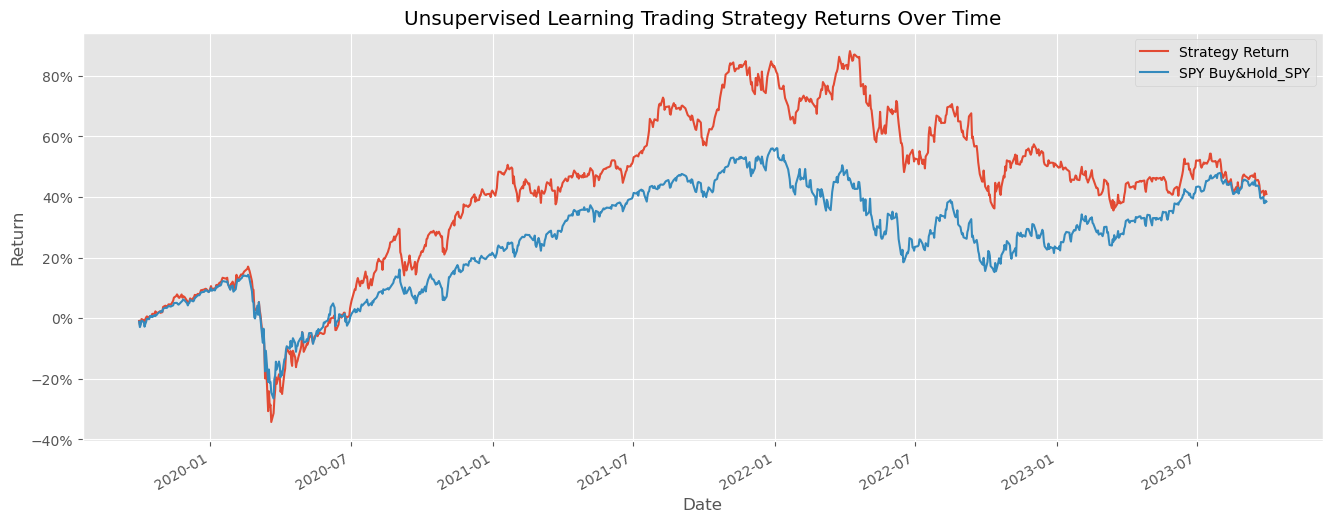

In [25]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
